In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf

In [15]:
# load csv of ground data with extractions
df = pd.read_csv('data/bm_extract/TB_all_bm_veg_idxs.csv', parse_dates=[1])
mod_bm = pickle.load(open('models/CPER_HLS_to_VOR_biomass_model_lr_simp.pk', 'rb'))

df['bm'] = df['bm_gm2'].astype('float') * 10.0

<AxesSubplot:ylabel='Frequency'>

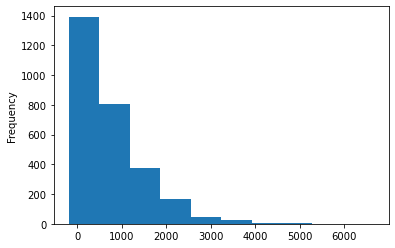

In [16]:
df['bm'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

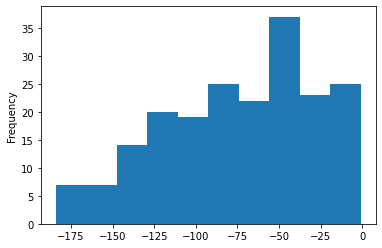

In [17]:
df.loc[df['bm'] < 0, 'bm'].plot.hist()

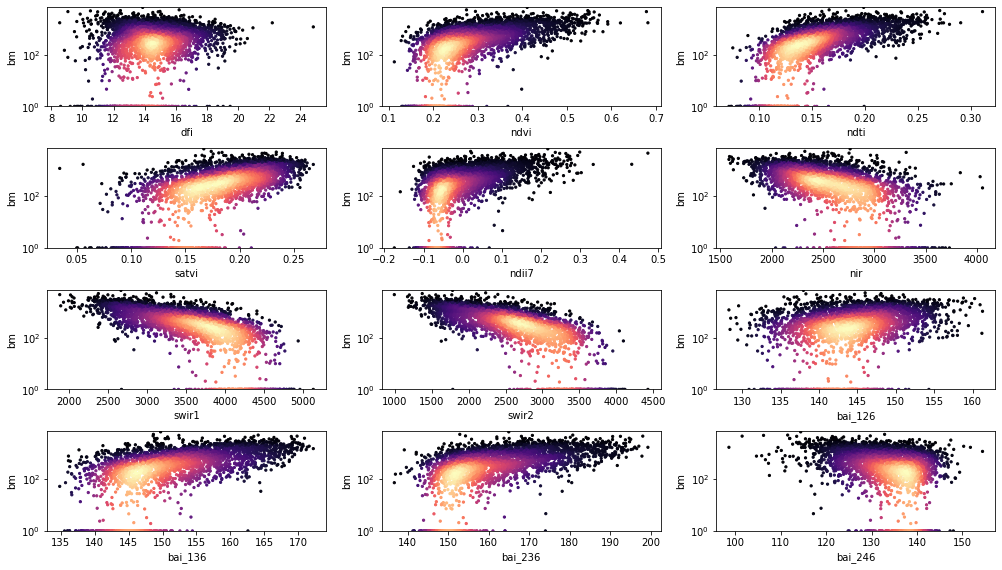

In [18]:
var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7',
             'nir', 'swir1', 'swir2',
            'bai_126', 'bai_136', 'bai_236', 'bai_246']
df['bm'] = df['bm_gm2'].astype('float') * 10.0
df.loc[df['bm'] < 0, 'bm'] = 1
#df['bm'] = df['bm'] + 200
df = df[(df['bm'].notnull()) & (df[var_names].notnull().any(axis=1))]
fig, axs = plt.subplots(figsize=(14, 8),
                        nrows=int(np.ceil(len(var_names) / 3)), ncols=3)
for idx, v in enumerate(var_names):
    xy_bm = np.vstack([df[v], df['bm']])
    z_bm = gaussian_kde(xy_bm)(xy_bm)
    df.plot.scatter(x=v, y='bm', logy=True, ax=axs.flatten()[idx], ylim=(1, 7000),
                    c=z_bm, cmap='magma', colorbar=False, s=5)
    plt.tight_layout(pad=1.0)

Explained variation per principal component: [0.63744866 0.2245978  0.07875583]


<Figure size 432x288 with 0 Axes>

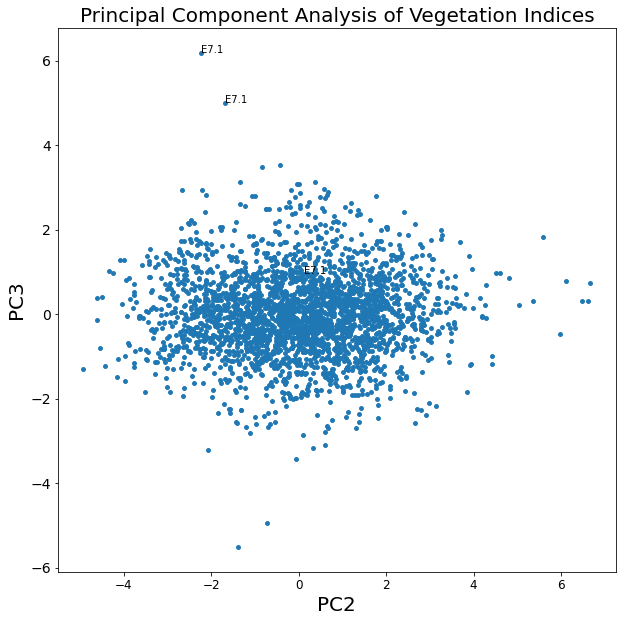

In [19]:
from sklearn.preprocessing import StandardScaler
x = df.loc[:, var_names].values
x = StandardScaler().fit_transform(x) # normalizing the features

from sklearn.decomposition import PCA
pca_vars = PCA(n_components=3)
principalComponents_df = pca_vars.fit_transform(x)

pca_df = pd.DataFrame(data = principalComponents_df,
                      columns = ['PC1', 
                                 'PC2',
                                 'PC3'])
print('Explained variation per principal component: {}'.format(pca_vars.explained_variance_ratio_))

pca_outliers = (pca_df < (pca_df.agg('mean') - pca_df.agg('std')*3)).any(axis=1) | (pca_df > (pca_df.agg('mean') + pca_df.agg('std')*3)).any(axis=1)

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC2',fontsize=20)
plt.ylabel('PC3',fontsize=20)
plt.title("Principal Component Analysis of Vegetation Indices",fontsize=20)
plt.scatter(pca_df['PC2'],
            pca_df['PC3'], s = 15)
for i, label in enumerate(df['ID']):
    if label == 'E7.1':
        plt.text(pca_df['PC2'].iloc[i],
                 pca_df['PC3'].iloc[i],
                 label)

In [20]:
import re
# remove outliers
df = df.reset_index()[~pca_outliers]

# fit model using cper variables
df['bm'] = df['bm_gm2'].astype('float') * 10.0
df.loc[df['bm'] < 0, 'bm'] = 1
lreg_cper_vars = smf.ols(formula=mod_bm.model.formula, data=df).fit()
#lreg_cper_vars = smf.ols(formula='bm ~ ndii7 + nir + bai_236 + ndii7:nir + ndii7:bai_236 + nir:bai_236', data=df).fit()
lreg_cper_vars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     bm   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     325.5
Date:                Tue, 19 Jul 2022   Prob (F-statistic):          1.09e-316
Time:                        12:54:34   Log-Likelihood:                -21657.
No. Observations:                2786   AIC:                         4.333e+04
Df Residuals:                    2779   BIC:                         4.337e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1002.0450   1517.947     -0.660      0.509   -3978.464    1974.374
ndii7          -601.8771   2993.453     -0.201      0.841   -6471.494    5267.740
nir               1.5386      0.601      2.559      0.011       0.359       2.718
bai_236          24.2805      9.380      2.589      0.010       5.888      42.673
ndii7:nir         1.4740      0.618      2.386      0.017       0.263       2.685
ndii7:bai_236    15.0594     12.237      1.231      0.219      -8.934      39.053
nir:bai_236      -0.0150      0.004     -3.985      0.000      -0.022      -0.008
==============================================================================
Omnibus:                      989.478   Durbin-Watson:                   1.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6128.720
Skew:                           1.546   Prob(JB):                         0.00
Kurtosis:                       9.575   Cond. No.                     1.16e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

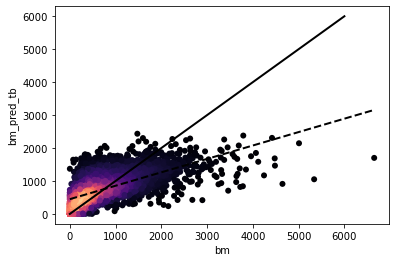

In [22]:
df['bm_pred_tb_log'] = lreg_cper_vars.predict(df)
df['bm_log'] = np.log(df['bm'])
df['bm_pred_tb'] = np.exp(lreg_cper_vars.predict(df))
df.loc[df['bm_pred_tb'] < 0, 'bm_pred_tb'] = 0
df = df[df['bm_pred_tb'].notnull()]
xy_bm = np.vstack([df['bm'],
                   df['bm_pred_tb']])
df['z_bm_tb'] = gaussian_kde(xy_bm)(xy_bm)
ax = plt.subplot()
sns.scatterplot(x='bm', y='bm_pred_tb', data=df, hue='z_bm_tb', 
                hue_norm=(1.1e-10, 1.1e-6), palette='magma', edgecolor='none', ax=ax)
sns.regplot(x='bm', y='bm_pred_tb', data=df, ci=None, marker='', order=1,
           line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2}, ax=ax)
ax.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')
plt.legend().remove()

In [9]:
display(df[['bm', 'bm_pred_tb']].corr())

,bm,bm_pred_tb
bm,1.000000,0.523459
bm_pred_tb,0.523459,1.000000


In [10]:
mae = round(np.mean(np.abs(df['bm_pred_tb'] - df['bm'])), 2)
mape = round(mae/df['bm'].mean() * 100, 2)
print('Mean Absolute Error: ' + str(mae))
print('Mean Absolute Percent Error: ' + str(mape))

Mean Absolute Error: 430.17
Mean Absolute Percent Error: 57.46


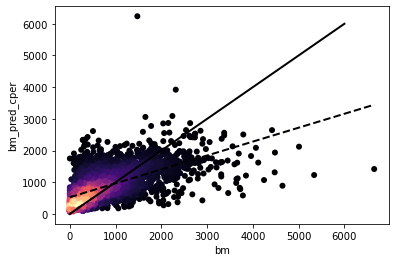

In [11]:
df['bm_pred_cper'] = np.exp(mod_bm.predict(df))
df.loc[df['bm_pred_cper'] < 0, 'bm_pred_cper'] = 0
df = df[df['bm_pred_cper'].notnull()]

xy_bm = np.vstack([df['bm'],
                   df['bm_pred_cper']])
df['z_bm_cper'] = gaussian_kde(xy_bm)(xy_bm)

ax = plt.subplot()
sns.scatterplot(x='bm', y='bm_pred_cper', data=df, hue='z_bm_cper', 
                hue_norm=(1.1e-10, 1.1e-6), palette='magma', edgecolor='none', ax=ax)
sns.regplot(x='bm', y='bm_pred_cper', data=df, ci=None, marker='', order=1,
           line_kws={'linestyle': 'dashed', 'color': 'black', 'linewidth': 2}, ax=ax)
ax.plot([0, 6000], [0, 6000], linewidth=2, c='black', linestyle='solid')
plt.legend().remove()

In [12]:
display(df[['bm', 'bm_pred_cper']].corr())

,bm,bm_pred_cper
bm,1.000000,0.612357
bm_pred_cper,0.612357,1.000000


In [13]:
mae = round(np.mean(np.abs(df['bm_pred_cper'] - df['bm'])), 2)
mape = round(mae/df['bm'].mean() * 100, 2)
print('Mean Absolute Error: ' + str(mae))
print('Mean Absolute Percent Error: ' + str(mape))

Mean Absolute Error: 424.76
Mean Absolute Percent Error: 56.74


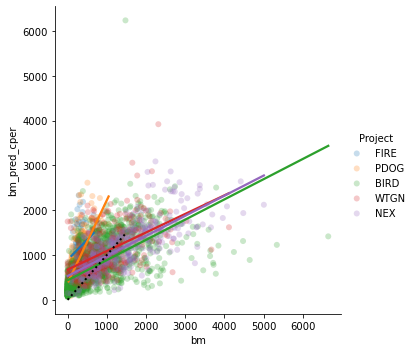

In [14]:
sns.lmplot(x='bm', y='bm_pred_cper', hue='Project', data=df, ci=None, 
           scatter_kws={'alpha':0.25, 'edgecolor':'none'})
plt.plot([0, 1500], [0, 1500], linewidth=2, c='black', linestyle='dotted')

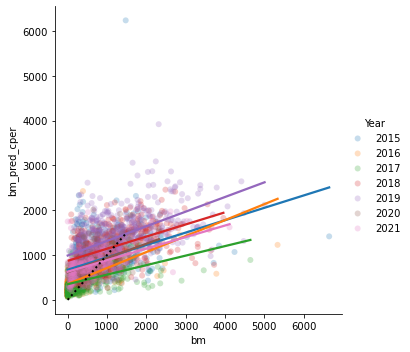

In [15]:
df['Year'] = df['Date'].dt.year
sns.lmplot(x='bm', y='bm_pred_cper', hue='Year', data=df,
           ci=None, scatter_kws={'alpha': 0.25, 'edgecolor':'none'})
plt.plot([0, 1500], [0, 1500], linewidth=2, c='black', linestyle='dotted')

# Run models

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold, KFold
import itertools
from tqdm.notebook import tqdm

In [17]:
# load csv of ground data with extractions
df = pd.read_csv('data/bm_extract/TB_all_bm_veg_idxs.csv', parse_dates=[1])
df['bm'] = df['bm_gm2'].astype('float') * 10.0
df.loc[df['bm'] < 0, 'bm'] = 1
df = df[(df['bm'].notnull()) & (df[var_names].notnull().any(axis=1))]
df['Year'] = df['Date'].dt.year

In [18]:
df = df.reset_index()[~pca_outliers]

In [19]:
df.groupby(['Project', 'Year']).ID.count()

Project  Year
BIRD     2015    412
         2016    390
         2017    405
         2018    282
         2019    254
FIRE     2015     90
NEX      2015     45
         2016     48
         2017     45
         2018     75
         2019     60
         2020     51
         2021     27
PDOG     2017     82
         2018     52
         2019     59
         2021     66
WTGN     2019    117
         2020    109
         2021    117
Name: ID, dtype: int64

### Run models cross-validated by year (temporal)

In [20]:
log_xfrm = True
wtd = False
poly = False
scale_vars = False
mod_logo = LeaveOneGroupOut()
scaler = StandardScaler(with_mean=True, with_std=False)

df_results = pd.DataFrame(columns=['model', 'numb_vars', 'formula', 'xv',
                                   'R2', 'R2_adj', 'AIC', 'rmse_kg_mean', 'rmse_kg_sd', 'mpe',
                                   'rmse_pct_mean', 'rmse_pct_sd', 'rmse_pct_max',
                                   'mae_kg_mean', 'mae_kg_sd', 'mae_orig_mean', 'mae_orig_sd',
                                   'rmse_orig_mean', 'rmse_orig_sd', 'rmse_orig_pct_mean', 'rmse_orig_pct_sd',
                                   'rmse_kg_low_mean', 'rmse_pct_low_mean', 'mpe_low'])
df_results_full = pd.DataFrame(columns=['model', 'kfold', 'numb_vars', 'formula', 'xv',
                                        'R2', 'R2_adj', 'AIC', 'rmse_kg', 'pe',
                                        'rmse_pct',  'rmse_orig',  'rmse_orig_pct',
                                        'rmse_kg_low', 'rmse_pct_low', 'pe_low'])
for k in tqdm(range(1, 6 + 1)):
    for combo in itertools.combinations(var_names, k):
        combo_corr = df[np.array(combo)].corr()
        if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
            continue
        else:
            if k == 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(bm) ~ ' + combo[0]
                else:
                    lr_form_simp = 'bm ~ ' + combo[0]
                if poly:
                    lr_form_simp = lr_form_simp + ' + I(' + combo[0] + '**2)'
                form_dict = dict(simp=lr_form_simp)
            if k > 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(bm) ~ ' + combo[0]
                else:
                    lr_form_simp = 'bm ~ ' + combo[0]
                for c in combo[1:]:
                    lr_form_simp = lr_form_simp + ' + ' + c
                for combo_c in itertools.combinations(combo, 2):
                    lr_form_simp = lr_form_simp + ' + ' + combo_c[0] + ':' + combo_c[1]
                if poly:
                    for c in combo:
                        lr_form_simp = lr_form_simp + ' + I(' + c + '**2)'
                form_dict = dict(simp=lr_form_simp)
            for f in form_dict:
                years_tmp = []
                r2_tmp = []
                r2_adj_tmp = []
                aic_tmp = []
                rmse_kg_tmp = []
                mae_kg_tmp = []
                mpe_tmp = []
                rmse_kg_low_tmp = []
                mean_kg_low_tmp = []
                mpe_low_tmp = []
                rmse_orig_tmp = []
                mae_orig_tmp = []
                for train_index, test_index in mod_logo.split(df, groups=df['Date'].dt.year):
                    df_train = df.iloc[train_index]
                    df_test = df.iloc[test_index]
                    if scale_vars:
                        scaler.fit(df_train[var_names])
                        df_train.loc[:, var_names] = scaler.transform(df_train[var_names])
                        df_test.loc[:, var_names] = scaler.transform(df_test[var_names])
                    if wtd:
                        lreg_k_tmp = smf.wls(formula=form_dict[f], data=df_train,
                                             weights=1 / df_train['bm']).fit()
                    else:
                        lreg_k_tmp = smf.ols(formula=form_dict[f], data=df_train).fit()
                    years_tmp.append(df_test['Date'].dt.year.unique()[0])
                    r2_tmp.append(lreg_k_tmp.rsquared)
                    r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
                    aic_tmp.append(lreg_k_tmp.aic)
                    if log_xfrm:
                        see_k_tmp = np.sqrt(np.sum((np.log(df['bm'].iloc[train_index]) -
                                                    lreg_k_tmp.predict(df.iloc[train_index])) ** 2) /
                                            (len(train_index) - len(lreg_k_tmp.params)))
                        cf_k_tmp = np.exp(see_k_tmp ** 2 / 2)  # correction factor from Sprugel 1983
                        pred_tmp = np.exp(lreg_k_tmp.predict(df_test))  # * cf_k_tmp
                        rmse_orig_tmp.append(np.sqrt(np.nanmean((lreg_k_tmp.predict(df_test) -
                                                                 np.log(df_test['bm'])) ** 2)))
                        mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test) - np.log(df_test['bm']))))
                    else:
                        pred_tmp = lreg_k_tmp.predict(df_test)
                        rmse_orig_tmp.append(np.nan)
                        rmse_orig_pct_tmp = np.nan
                        mae_orig_tmp.append(np.nan)
                    low_idx = df_test['bm'] < 700
                    rmse_kg_tmp.append(np.sqrt(np.nanmean((pred_tmp - df_test['bm']) ** 2)))
                    mae_kg_tmp.append(np.nanmean(np.abs(np.exp(lreg_k_tmp.predict(df_test)) - df_test['bm'])))
                    mpe_tmp.append(np.nanmean((pred_tmp - df_test['bm']) / df_test['bm']))
                    rmse_kg_low_tmp.append(
                        np.sqrt(np.nanmean((pred_tmp[low_idx] - df_test['bm'][low_idx]) ** 2)))
                    mean_kg_low_tmp.append(df_test['bm'][low_idx].mean())
                    mpe_low_tmp.append(np.nanmean((pred_tmp[low_idx] - df_test['bm'][low_idx]) /
                                                  df_test['bm'][low_idx]))
                rmse_pct_tmp = np.array(rmse_kg_tmp) / df.groupby('Year')['bm'].mean()
                rmse_orig_pct_tmp = np.array(rmse_orig_tmp) / \
                                    df.groupby('Year')['bm'].apply(lambda x: np.log(x).mean())
                rmse_pct_low_tmp = np.array(rmse_kg_low_tmp) / np.array(mean_kg_low_tmp)
                mae_pct_tmp = np.array(mae_kg_tmp) / df.groupby('Year')['bm'].mean()
                if wtd:
                    lreg_all_tmp = smf.wls(formula=form_dict[f], data=df,
                                           weights=1 / df['bm']).fit()
                else:
                    lreg_all_tmp = smf.ols(formula=form_dict[f], data=df).fit()
                df_results_tmp = pd.DataFrame(dict(model='Temporal',
                                                   numb_vars=[k],
                                                   formula=[form_dict[f]],
                                                   xv=[f],
                                                   R2=round(lreg_all_tmp.rsquared, 4),
                                                   R2_adj=round(lreg_all_tmp.rsquared_adj, 4),
                                                   AIC=round(lreg_all_tmp.aic, 4),
                                                   rmse_kg_mean=round(np.mean(rmse_kg_tmp), 4),
                                                   rmse_kg_sd=round(np.std(rmse_kg_tmp), 4),
                                                   mae_kg_mean=round(np.mean(mae_kg_tmp), 4),
                                                   mae_kg_sd=round(np.std(mae_kg_tmp), 4),
                                                   mae_kg_max=round(np.max(mae_kg_tmp), 4),
                                                   mpe=round(np.mean(mpe_tmp), 4),
                                                   rmse_pct_mean=round(np.mean(rmse_pct_tmp), 4),
                                                   rmse_pct_sd=round(np.std(rmse_pct_tmp), 4),
                                                   rmse_pct_max=round(np.max(rmse_pct_tmp), 4),
                                                   rmse_orig_mean=round(np.mean(rmse_orig_tmp), 4),
                                                   rmse_orig_sd=round(np.std(rmse_orig_tmp), 4),
                                                   rmse_orig_pct_mean=round(np.mean(rmse_orig_pct_tmp), 4),
                                                   rmse_orig_pct_sd=round(np.std(rmse_orig_pct_tmp), 4),
                                                   mae_orig_mean=round(np.mean(mae_orig_tmp), 4),
                                                   mae_orig_sd=round(np.std(mae_orig_tmp), 4),
                                                   mae_pct_mean=round(np.mean(mae_pct_tmp), 4),
                                                   mae_pct_sd=round(np.std(mae_pct_tmp), 4),
                                                   mae_pct_max=round(np.max(mae_pct_tmp), 4),
                                                   rmse_kg_low_mean=round(np.mean(rmse_kg_low_tmp), 4),
                                                   rmse_pct_low_mean=round(np.mean(rmse_pct_low_tmp), 4),
                                                   mpe_low=round(np.mean(mpe_low_tmp), 4)))
                df_results_full_tmp = pd.DataFrame(dict(model='Temporal',
                                                        kfold=years_tmp,
                                                        numb_vars=np.repeat(k, len(r2_tmp)),
                                                        formula=np.repeat(form_dict[f], len(r2_tmp)),
                                                        xv=np.repeat(f, len(r2_tmp)),
                                                        R2=np.round(r2_tmp, 4),
                                                        R2_adj=np.round(r2_adj_tmp, 4),
                                                        AIC=np.round(aic_tmp, 4),
                                                        rmse_kg=np.round(rmse_kg_tmp, 4),
                                                        mae_kg=np.round(mae_kg_tmp, 4),
                                                        pe=np.round(mpe_tmp, 4),
                                                        rmse_pct=round(rmse_pct_tmp, 4),
                                                        rmse_orig=np.round(rmse_orig_tmp, 4),
                                                        mae_pct=np.round(mae_pct_tmp, 4),
                                                        mae_orig=np.round(mae_orig_tmp, 4),
                                                        rmse_orig_pct=round(rmse_orig_pct_tmp, 4),
                                                        rmse_kg_low=np.round(rmse_kg_low_tmp, 4),
                                                        rmse_pct_low=np.round(rmse_pct_low_tmp, 4),
                                                        pe_low=np.round(mpe_low_tmp, 4)))
                df_results = pd.concat([df_results, df_results_tmp])
                df_results_full = pd.concat([df_results_full,
                                             df_results_full_tmp.reset_index(drop=True)])

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
df_results['index'] = np.arange(len(df_results))
df_results = df_results.set_index('index')

df_results.to_csv("data/bm_modeling/tb_vor_lreg_results.csv")
df_results_full.to_csv("data/bm_modeling/tb_vor_lreg_results_full.csv")

### Run models with stratified random sampling across project-X-year

In [22]:
df['projyear'] = df.apply(lambda x: '_'.join([x['Project'], str(x['Year'])]), axis=1)

In [23]:
df_results = pd.DataFrame(columns=['model', 'numb_vars', 'formula',
                                   'R2', 'R2_adj', 'AIC', 'rmse_kg_mean', 'rmse_kg_sd', 'mpe',
                                   'rmse_pct_mean', 'rmse_pct_sd', 'rmse_pct_max',
                                   'mae_kg_mean|', 'mae_kg_sd', 'mae_orig_mean', 'mae_orig_sd',
                                   'rmse_orig_mean', 'rmse_orig_sd', 'rmse_orig_pct_mean', 'rmse_orig_pct_sd',
                                   'rmse_kg_low_mean', 'rmse_pct_low_mean', 'mpe_low'])
df_results_full = pd.DataFrame(columns=['model', 'kfold', 'numb_vars', 'formula',
                                        'R2', 'R2_adj', 'AIC', 'rmse_kg', 'pe',
                                        'rmse_pct',  'rmse_orig',  'rmse_orig_pct',
                                        'rmse_kg_low', 'rmse_pct_low', 'pe_low'])

In [24]:
nfolds = 5
mod_kstrat = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=432)

for k in tqdm(range(1, 6 + 1)):
    for combo in itertools.combinations(var_names, k):
        combo_corr = df[np.array(combo)].corr()
        if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
            continue
        else:
            if k == 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(bm) ~ ' + combo[0]
                else:
                    lr_form_simp = 'bm ~ ' + combo[0]
                if poly:
                    lr_form_simp = lr_form_simp + ' + I(' + combo[0] + '**2)'
                form_dict = dict(simp=lr_form_simp)
            if k > 1:
                if log_xfrm:
                    lr_form_simp = 'np.log(bm) ~ ' + combo[0]
                else:
                    lr_form_simp = 'bm ~ ' + combo[0]
                for c in combo[1:]:
                    lr_form_simp = lr_form_simp + ' + ' + c
                for combo_c in itertools.combinations(combo, 2):
                    lr_form_simp = lr_form_simp + ' + ' + combo_c[0] + ':' + combo_c[1]
                if poly:
                    for c in combo:
                        lr_form_simp = lr_form_simp + ' + I(' + c + '**2)'
                form_dict = dict(simp=lr_form_simp)
            for f in form_dict:
                r2_tmp = []
                r2_adj_tmp = []
                aic_tmp = []
                rmse_kg_tmp = []
                mae_kg_tmp = []
                mpe_tmp = []
                rmse_kg_low_tmp = []
                mean_kg_low_tmp = []
                mpe_low_tmp = []
                rmse_orig_tmp = []
                mae_orig_tmp = []
                for train_index, test_index in mod_kstrat.split(X=df, y=df['projyear']):
                    df_train = df.iloc[train_index]
                    df_test = df.iloc[test_index]
                    if scale_vars:
                        scaler.fit(df_train[var_names])
                        df_train.loc[:, var_names] = scaler.transform(df_train[var_names])
                        df_test.loc[:, var_names] = scaler.transform(df_test[var_names])
                    if wtd:
                        lreg_k_tmp = smf.wls(formula=form_dict[f], data=df_train,
                                             weights=1 / df_train['bm']).fit()
                    else:
                        lreg_k_tmp = smf.ols(formula=form_dict[f], data=df_train).fit()
                    r2_tmp.append(lreg_k_tmp.rsquared)
                    r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
                    aic_tmp.append(lreg_k_tmp.aic)
                    if log_xfrm:
                        see_k_tmp = np.sqrt(np.sum((np.log(df['bm'].iloc[train_index]) -
                                                    lreg_k_tmp.predict(df.iloc[train_index])) ** 2) /
                                            (len(train_index) - len(lreg_k_tmp.params)))
                        cf_k_tmp = np.exp(see_k_tmp ** 2 / 2)  # correction factor from Sprugel 1983
                        pred_tmp = np.exp(lreg_k_tmp.predict(df_test))  # * cf_k_tmp
                        rmse_orig_tmp.append(np.sqrt(np.nanmean((lreg_k_tmp.predict(df_test) -
                                                                 np.log(df_test['bm'])) ** 2)))
                        mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test) - np.log(df_test['bm']))))
                    else:
                        pred_tmp = lreg_k_tmp.predict(df_test)
                        rmse_orig_tmp.append(np.nan)
                        rmse_orig_pct_tmp = np.nan
                        mae_orig_tmp.append(np.nan)
                    low_idx = df_test['bm'] < 700
                    rmse_kg_tmp.append(np.sqrt(np.nanmean((pred_tmp - df_test['bm']) ** 2)))
                    mae_kg_tmp.append(np.nanmean(np.abs(np.exp(lreg_k_tmp.predict(df_test)) - df_test['bm'])))
                    mpe_tmp.append(np.nanmean((pred_tmp - df_test['bm']) / df_test['bm']))
                    rmse_kg_low_tmp.append(
                        np.sqrt(np.nanmean((pred_tmp[low_idx] - df_test['bm'][low_idx]) ** 2)))
                    mean_kg_low_tmp.append(df_test['bm'][low_idx].mean())
                    mpe_low_tmp.append(np.nanmean((pred_tmp[low_idx] - df_test['bm'][low_idx]) /
                                                  df_test['bm'][low_idx]))
                rmse_pct_tmp = np.array(rmse_kg_tmp) / df['bm'].mean()
                rmse_orig_pct_tmp = np.array(rmse_orig_tmp) / \
                                    df['bm'].apply('log').mean()
                rmse_pct_low_tmp = np.array(rmse_kg_low_tmp) / np.array(mean_kg_low_tmp)
                mae_pct_tmp = np.array(mae_kg_tmp) / df['bm'].mean()
                if wtd:
                    lreg_all_tmp = smf.wls(formula=form_dict[f], data=df,
                                           weights=1 / df['bm']).fit()
                else:
                    lreg_all_tmp = smf.ols(formula=form_dict[f], data=df).fit()
                df_results_tmp = pd.DataFrame(dict(model='projyear',
                                                   numb_vars=[k],
                                                   formula=[form_dict[f]],
                                                   R2=round(lreg_all_tmp.rsquared, 4),
                                                   R2_adj=round(lreg_all_tmp.rsquared_adj, 4),
                                                   AIC=round(lreg_all_tmp.aic, 4),
                                                   rmse_kg_mean=round(np.mean(rmse_kg_tmp), 4),
                                                   rmse_kg_sd=round(np.std(rmse_kg_tmp), 4),
                                                   mae_kg_mean=round(np.mean(mae_kg_tmp), 4),
                                                   mae_kg_sd=round(np.std(mae_kg_tmp), 4),
                                                   mae_kg_max=round(np.max(mae_kg_tmp), 4),
                                                   mpe=round(np.mean(mpe_tmp), 4),
                                                   rmse_pct_mean=round(np.mean(rmse_pct_tmp), 4),
                                                   rmse_pct_sd=round(np.std(rmse_pct_tmp), 4),
                                                   rmse_pct_max=round(np.max(rmse_pct_tmp), 4),
                                                   rmse_orig_mean=round(np.mean(rmse_orig_tmp), 4),
                                                   rmse_orig_sd=round(np.std(rmse_orig_tmp), 4),
                                                   rmse_orig_pct_mean=round(np.mean(rmse_orig_pct_tmp), 4),
                                                   rmse_orig_pct_sd=round(np.std(rmse_orig_pct_tmp), 4),
                                                   mae_orig_mean=round(np.mean(mae_orig_tmp), 4),
                                                   mae_orig_sd=round(np.std(mae_orig_tmp), 4),
                                                   mae_pct_mean=round(np.mean(mae_pct_tmp), 4),
                                                   mae_pct_sd=round(np.std(mae_pct_tmp), 4),
                                                   mae_pct_max=round(np.max(mae_pct_tmp), 4),
                                                   rmse_kg_low_mean=round(np.mean(rmse_kg_low_tmp), 4),
                                                   rmse_pct_low_mean=round(np.mean(rmse_pct_low_tmp), 4),
                                                   mpe_low=round(np.mean(mpe_low_tmp), 4)))
                df_results_full_tmp = pd.DataFrame(dict(model='projyear',
                                                        kfold=np.arange(1, nfolds+1),
                                                        numb_vars=np.repeat(k, len(r2_tmp)),
                                                        formula=np.repeat(form_dict[f], len(r2_tmp)),
                                                        R2=np.round(r2_tmp, 4),
                                                        R2_adj=np.round(r2_adj_tmp, 4),
                                                        AIC=np.round(aic_tmp, 4),
                                                        rmse_kg=np.round(rmse_kg_tmp, 4),
                                                        mae_kg=np.round(mae_kg_tmp, 4),
                                                        pe=np.round(mpe_tmp, 4),
                                                        rmse_pct=np.round(rmse_pct_tmp, 4),
                                                        rmse_orig=np.round(rmse_orig_tmp, 4),
                                                        mae_pct=np.round(mae_pct_tmp, 4),
                                                        mae_orig=np.round(mae_orig_tmp, 4),
                                                        rmse_orig_pct=np.round(rmse_orig_pct_tmp, 4),
                                                        rmse_kg_low=np.round(rmse_kg_low_tmp, 4),
                                                        rmse_pct_low=np.round(rmse_pct_low_tmp, 4),
                                                        pe_low=np.round(mpe_low_tmp, 4)))
                df_results = pd.concat([df_results, df_results_tmp])
                df_results_full = pd.concat([df_results_full,
                                             df_results_full_tmp.reset_index(drop=True)])

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
df_test.groupby(['Project', 'Year']).ID.count()

Project  Year
BIRD     2015    83
         2016    78
         2017    81
         2018    56
         2019    51
FIRE     2015    18
NEX      2015     9
         2016     9
         2017     9
         2018    15
         2019    12
         2020    10
         2021     6
PDOG     2017    16
         2018    10
         2019    12
         2021    13
WTGN     2019    23
         2020    22
         2021    24
Name: ID, dtype: int64

In [26]:
df_results.to_csv("data/bm_modeling/tb_vor_lreg_results_strat_projyear.csv")
df_results_full.to_csv("data/bm_modeling/tb_vor_lreg_results_strat_projyear_full.csv")

### Run models separately for each project

In [35]:
df_results = pd.DataFrame(columns=['model', 'numb_vars', 'formula', 'project',
                                   'R2', 'R2_adj', 'AIC', 'rmse_kg_mean', 'rmse_kg_sd', 'mpe',
                                   'rmse_pct_mean', 'rmse_pct_sd', 'rmse_pct_max',
                                   'mae_kg_mean|', 'mae_kg_sd', 'mae_orig_mean', 'mae_orig_sd',
                                   'rmse_orig_mean', 'rmse_orig_sd', 'rmse_orig_pct_mean', 'rmse_orig_pct_sd',
                                   'rmse_kg_low_mean', 'rmse_pct_low_mean', 'mpe_low'])
df_results_full = pd.DataFrame(columns=['model', 'kfold', 'numb_vars', 'formula', 'project',
                                        'R2', 'R2_adj', 'AIC', 'rmse_kg', 'pe',
                                        'rmse_pct',  'rmse_orig',  'rmse_orig_pct',
                                        'rmse_kg_low', 'rmse_pct_low', 'pe_low'])

In [36]:
nfolds = 5
mod_kfold = KFold(n_splits=nfolds, shuffle=True, random_state=432)

for proj, df_proj in df.groupby('Project'):
    print('--------------- ', proj, ' --------------------')
    for k in tqdm(range(1, 6 + 1)):
        for combo in itertools.combinations(var_names, k):
            combo_corr = df_proj[np.array(combo)].corr()
            if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
                continue
            else:
                if k == 1:
                    if log_xfrm:
                        lr_form_simp = 'np.log(bm) ~ ' + combo[0]
                    else:
                        lr_form_simp = 'bm ~ ' + combo[0]
                    if poly:
                        lr_form_simp = lr_form_simp + ' + I(' + combo[0] + '**2)'
                    form_dict = dict(simp=lr_form_simp)
                if k > 1:
                    if log_xfrm:
                        lr_form_simp = 'np.log(bm) ~ ' + combo[0]
                    else:
                        lr_form_simp = 'bm ~ ' + combo[0]
                    for c in combo[1:]:
                        lr_form_simp = lr_form_simp + ' + ' + c
                    for combo_c in itertools.combinations(combo, 2):
                        lr_form_simp = lr_form_simp + ' + ' + combo_c[0] + ':' + combo_c[1]
                    if poly:
                        for c in combo:
                            lr_form_simp = lr_form_simp + ' + I(' + c + '**2)'
                    form_dict = dict(simp=lr_form_simp)
                for f in form_dict:
                    r2_tmp = []
                    r2_adj_tmp = []
                    aic_tmp = []
                    rmse_kg_tmp = []
                    mae_kg_tmp = []
                    mpe_tmp = []
                    rmse_kg_low_tmp = []
                    mean_kg_low_tmp = []
                    mpe_low_tmp = []
                    rmse_orig_tmp = []
                    mae_orig_tmp = []
                    for train_index, test_index in mod_kfold.split(X=df_proj):
                        df_train = df_proj.iloc[train_index]
                        df_test = df_proj.iloc[test_index]
                        if scale_vars:
                            scaler.fit(df_train[var_names])
                            df_train.loc[:, var_names] = scaler.transform(df_train[var_names])
                            df_test.loc[:, var_names] = scaler.transform(df_test[var_names])
                        if wtd:
                            lreg_k_tmp = smf.wls(formula=form_dict[f], data=df_train,
                                                 weights=1 / df_train['bm']).fit()
                        else:
                            lreg_k_tmp = smf.ols(formula=form_dict[f], data=df_train).fit()
                        r2_tmp.append(lreg_k_tmp.rsquared)
                        r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
                        aic_tmp.append(lreg_k_tmp.aic)
                        if log_xfrm:
                            see_k_tmp = np.sqrt(np.sum((np.log(df_proj['bm'].iloc[train_index]) -
                                                        lreg_k_tmp.predict(df_proj.iloc[train_index])) ** 2) /
                                                (len(train_index) - len(lreg_k_tmp.params)))
                            cf_k_tmp = np.exp(see_k_tmp ** 2 / 2)  # correction factor from Sprugel 1983
                            pred_tmp = np.exp(lreg_k_tmp.predict(df_test))  # * cf_k_tmp
                            rmse_orig_tmp.append(np.sqrt(np.nanmean((lreg_k_tmp.predict(df_test) -
                                                                     np.log(df_test['bm'])) ** 2)))
                            mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test) - np.log(df_test['bm']))))
                        else:
                            pred_tmp = lreg_k_tmp.predict(df_test)
                            rmse_orig_tmp.append(np.nan)
                            rmse_orig_pct_tmp = np.nan
                            mae_orig_tmp.append(np.nan)
                        low_idx = df_test['bm'] < 700
                        rmse_kg_tmp.append(np.sqrt(np.nanmean((pred_tmp - df_test['bm']) ** 2)))
                        mae_kg_tmp.append(np.nanmean(np.abs(np.exp(lreg_k_tmp.predict(df_test)) - df_test['bm'])))
                        mpe_tmp.append(np.nanmean((pred_tmp - df_test['bm']) / df_test['bm']))
                        rmse_kg_low_tmp.append(
                            np.sqrt(np.nanmean((pred_tmp[low_idx] - df_test['bm'][low_idx]) ** 2)))
                        mean_kg_low_tmp.append(df_test['bm'][low_idx].mean())
                        mpe_low_tmp.append(np.nanmean((pred_tmp[low_idx] - df_test['bm'][low_idx]) /
                                                      df_test['bm'][low_idx]))
                    rmse_pct_tmp = np.array(rmse_kg_tmp) / df_proj['bm'].mean()
                    rmse_orig_pct_tmp = np.array(rmse_orig_tmp) / \
                                        df_proj['bm'].apply('log').mean()
                    rmse_pct_low_tmp = np.array(rmse_kg_low_tmp) / np.array(mean_kg_low_tmp)
                    mae_pct_tmp = np.array(mae_kg_tmp) / df_proj['bm'].mean()
                    if wtd:
                        lreg_all_tmp = smf.wls(formula=form_dict[f], data=df_proj,
                                               weights=1 / df_proj['bm']).fit()
                    else:
                        lreg_all_tmp = smf.ols(formula=form_dict[f], data=df_proj).fit()
                    df_results_tmp = pd.DataFrame(dict(model='Project',
                                                       numb_vars=[k],
                                                       formula=[form_dict[f]],
                                                       project=proj,
                                                       R2=round(lreg_all_tmp.rsquared, 4),
                                                       R2_adj=round(lreg_all_tmp.rsquared_adj, 4),
                                                       AIC=round(lreg_all_tmp.aic, 4),
                                                       rmse_kg_mean=round(np.mean(rmse_kg_tmp), 4),
                                                       rmse_kg_sd=round(np.std(rmse_kg_tmp), 4),
                                                       mae_kg_mean=round(np.mean(mae_kg_tmp), 4),
                                                       mae_kg_sd=round(np.std(mae_kg_tmp), 4),
                                                       mae_kg_max=round(np.max(mae_kg_tmp), 4),
                                                       mpe=round(np.mean(mpe_tmp), 4),
                                                       rmse_pct_mean=round(np.mean(rmse_pct_tmp), 4),
                                                       rmse_pct_sd=round(np.std(rmse_pct_tmp), 4),
                                                       rmse_pct_max=round(np.max(rmse_pct_tmp), 4),
                                                       rmse_orig_mean=round(np.mean(rmse_orig_tmp), 4),
                                                       rmse_orig_sd=round(np.std(rmse_orig_tmp), 4),
                                                       rmse_orig_pct_mean=round(np.mean(rmse_orig_pct_tmp), 4),
                                                       rmse_orig_pct_sd=round(np.std(rmse_orig_pct_tmp), 4),
                                                       mae_orig_mean=round(np.mean(mae_orig_tmp), 4),
                                                       mae_orig_sd=round(np.std(mae_orig_tmp), 4),
                                                       mae_pct_mean=round(np.mean(mae_pct_tmp), 4),
                                                       mae_pct_sd=round(np.std(mae_pct_tmp), 4),
                                                       mae_pct_max=round(np.max(mae_pct_tmp), 4),
                                                       rmse_kg_low_mean=round(np.mean(rmse_kg_low_tmp), 4),
                                                       rmse_pct_low_mean=round(np.mean(rmse_pct_low_tmp), 4),
                                                       mpe_low=round(np.mean(mpe_low_tmp), 4)))
                    df_results_full_tmp = pd.DataFrame(dict(model='Project',
                                                            kfold=np.arange(1, nfolds+1),
                                                            numb_vars=np.repeat(k, len(r2_tmp)),
                                                            formula=np.repeat(form_dict[f], len(r2_tmp)),
                                                            project=np.repeat(proj, len(r2_tmp)),
                                                            R2=np.round(r2_tmp, 4),
                                                            R2_adj=np.round(r2_adj_tmp, 4),
                                                            AIC=np.round(aic_tmp, 4),
                                                            rmse_kg=np.round(rmse_kg_tmp, 4),
                                                            mae_kg=np.round(mae_kg_tmp, 4),
                                                            pe=np.round(mpe_tmp, 4),
                                                            rmse_pct=np.round(rmse_pct_tmp, 4),
                                                            rmse_orig=np.round(rmse_orig_tmp, 4),
                                                            mae_pct=np.round(mae_pct_tmp, 4),
                                                            mae_orig=np.round(mae_orig_tmp, 4),
                                                            rmse_orig_pct=np.round(rmse_orig_pct_tmp, 4),
                                                            rmse_kg_low=np.round(rmse_kg_low_tmp, 4),
                                                            rmse_pct_low=np.round(rmse_pct_low_tmp, 4),
                                                            pe_low=np.round(mpe_low_tmp, 4)))
                    df_results = pd.concat([df_results, df_results_tmp])
                    df_results_full = pd.concat([df_results_full,
                                                 df_results_full_tmp.reset_index(drop=True)])

---------------  BIRD  --------------------


  0%|          | 0/6 [00:00<?, ?it/s]

---------------  FIRE  --------------------


  0%|          | 0/6 [00:00<?, ?it/s]

---------------  NEX  --------------------


  0%|          | 0/6 [00:00<?, ?it/s]

---------------  PDOG  --------------------


  0%|          | 0/6 [00:00<?, ?it/s]

---------------  WTGN  --------------------


  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
df_results['index'] = np.arange(len(df_results))
df_results = df_results.set_index('index')

In [38]:
df_results.to_csv("data/bm_modeling/tb_vor_lreg_results_byproj.csv")
df_results_full.to_csv("data/bm_modeling/tb_vor_lreg_results_byproj_full.csv")

In [31]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_results[df_results['project'] == 'WTGN'].sort_values('mae_orig_mean', ascending=True).head(10))

         model numb_vars                                            formula  \
index                                                                         
1587   Project         3  np.log(bm) ~ dfi + nir + bai_246 + dfi:nir + d...   
1510   Project         2                 np.log(bm) ~ dfi + ndvi + dfi:ndvi   
1560   Project         3  np.log(bm) ~ dfi + ndvi + nir + dfi:ndvi + dfi...   
1511   Project         2                 np.log(bm) ~ dfi + ndti + dfi:ndti   
1564   Project         3  np.log(bm) ~ dfi + ndti + nir + dfi:ndti + dfi...   
1565   Project         3  np.log(bm) ~ dfi + ndti + swir1 + dfi:ndti + d...   
1527   Project         2             np.log(bm) ~ ndti + swir1 + ndti:swir1   
1568   Project         3  np.log(bm) ~ dfi + ndti + bai_236 + dfi:ndti +...   
1561   Project         3  np.log(bm) ~ dfi + ndvi + bai_126 + dfi:ndvi +...   
1526   Project         2                 np.log(bm) ~ ndti + nir + ndti:nir   

      project      R2  R2_adj        AIC  rmse_kg_m